In [1]:
# reference: https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import pickle
f = open("data/author_sentence.pickle","rb")
df = pickle.load(f)
f.close()
train = df
train.head()

,sentence,author
0,EUGENIE GRANDET By Honore De Balzac Translate...,"Balzac, Honoré de"
1,"May your name, that of one whose portrait is t...","Balzac, Honoré de"
2,De Balzac.,"Balzac, Honoré de"
3,EUGENIE GRANDET I There are houses in certain ...,"Balzac, Honoré de"
4,"Within these houses there is, perhaps, the sil...","Balzac, Honoré de"


### Basic Exploratory Data Analysis (EDA)

In [3]:
train['author'].value_counts()

Parker, Gilbert                        177943
Shakespeare, William                   176265
Alger, Horatio, Jr.                    134267
Fenn, George Manville                  125575
Meredith, George                       109713
Dickens, Charles                        88597
Kingston, William Henry Giles           86446
Twain, Mark                             85641
Jacobs, W. W. (William Wymark)          84617
Stevenson, Robert Louis                 83999
Balzac, Honoré de                       82624
Oliphant, Mrs. (Margaret)               81870
Ballantyne, R. M. (Robert Michael)      81822
Henty, G. A. (George Alfred)            81381
Ebers, Georg                            79221
Howells, William Dean                   77060
Lytton, Edward Bulwer Lytton, Baron     75294
Hawthorne, Nathaniel                    70744
Motley, John Lothrop                    65628
Pepys, Samuel                           56141
Name: author, dtype: int64

In [4]:
# Reanme
train.rename(columns = {'sentence':'text'}, inplace = True) 
train

,text,author
0,EUGENIE GRANDET By Honore De Balzac Translate...,"Balzac, Honoré de"
1,"May your name, that of one whose portrait is t...","Balzac, Honoré de"
2,De Balzac.,"Balzac, Honoré de"
3,EUGENIE GRANDET I There are houses in certain ...,"Balzac, Honoré de"
4,"Within these houses there is, perhaps, the sil...","Balzac, Honoré de"
...,...,...
1904843,But Abdul Jemalee was not a man of observation.,"Ballantyne, R. M. (Robert Michael)"
1904844,"He did not care a straw for these things, and ...","Ballantyne, R. M. (Robert Michael)"
1904845,"There is no necessary antagonism, however, bet...","Ballantyne, R. M. (Robert Michael)"
1904846,Circumstances and men have at present thrown a...,"Ballantyne, R. M. (Robert Michael)"


## Data Preprocessing

### Removing all notations

In [5]:
import re
def data_clearing_combined(text):
    
    regex = r'([0-9~`!@#$%^&*()\-_=+\[\]{};:\'",.<>?\/\\“”‘’|「」【】¥])'
    result = re.compile(regex)
    return result.sub(r'',text)
                                  
# Clear training Text
train['text'] = train['text'].apply(lambda x : data_clearing_combined(str(x)))
train['text']

0           EUGENIE GRANDET By Honore De Balzac Translate...
1          May your name that of one whose portrait is th...
2                                                  De Balzac
3          EUGENIE GRANDET I There are houses in certain ...
4          Within these houses there is perhaps the silen...
                                 ...                        
1904843       But Abdul Jemalee was not a man of observation
1904844    He did not care a straw for these things and a...
1904845    There is no necessary antagonism however betwe...
1904846    Circumstances and men have at present thrown a...
1904847                                              THE END
Name: text, Length: 1904848, dtype: object

### Removing short text length

In [6]:
max_length = train['text'].map(len).max()
max_length

14176

In [7]:
text_len_freq = []

for index in range(max_length + 1):
    text_len_freq.append(0)

for text in train['text']:
    text_len_freq[len(text)] += 1

text_len_freq = pd.DataFrame(text_len_freq).rename(columns={0:'frequency'})
text_len_freq

,frequency
0,10655
1,2282
2,15766
3,10341
4,14869
...,...
14172,0
14173,0
14174,0
14175,0


In [8]:
length = 50
text_len_freq = []

for index in range(length + 1):
    text_len_freq.append(0)

for text in train['text']:
    if len(text) <= length:
        text_len_freq[len(text)] += 1

text_len_freq = pd.DataFrame(text_len_freq).rename(columns={0:'frequency'})
# text_len_freq 

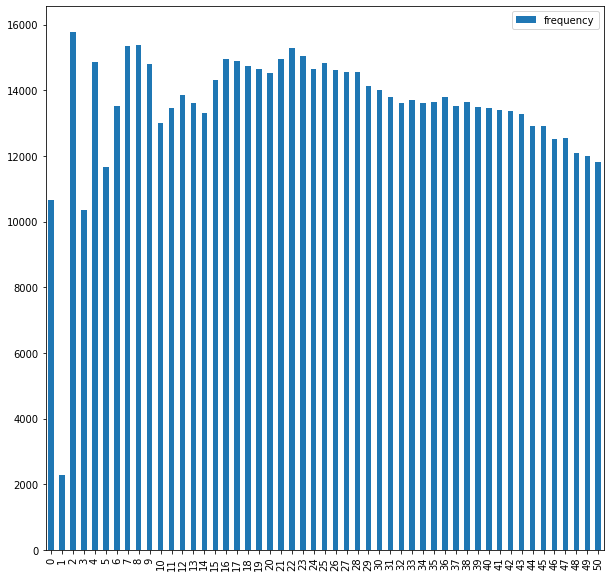

In [9]:
text_len_freq.plot.bar(figsize=(10,10))

In [10]:
length = 100

# Drop outlines
print("Data size before removing outlines: ", len(train))
indexNames = []
for key in train['text'].keys():
    if len(train['text'][key]) <= length:
        indexNames.append(key)
train.drop(indexNames , inplace=True)
print("Data size after removing outlines: ", len(train))

Data size before removing outlines:  1904848
Data size after removing outlines:  745971


### Sampling for author Pepys Samuel

In [11]:
Pepys_Samuel = train[ train['author'] == 'Pepys, Samuel' ]
Pepys_Samuel

,text,author
258891,CLERK OF THE ACTS AND SECRETARY TO THE ADMIRAL...,"Pepys, Samuel"
258893,LATE FELLOW AND PRESIDENT OF THE COLLEGE Unabr...,"Pepys, Samuel"
258896,Lay very long in bed discoursing with Mr Hill ...,"Pepys, Samuel"
258897,At last up and it being a very foule day for r...,"Pepys, Samuel"
258898,However I dined well and after dinner all on s...,"Pepys, Samuel"
...,...,...
315024,Hugged it being cold now in the mornings Hunt ...,"Pepys, Samuel"
315026,Never while he lives truckle under any body or...,"Pepys, Samuel"
315027,Stewards face Night the Dutch burned our ships...,"Pepys, Samuel"
315028,They want where to set their feet to begin to ...,"Pepys, Samuel"


In [12]:
Pepys_Samuel_text = []
Pepys_Samuel_text.append(" ".join(Pepys_Samuel['text']))
# Pepys_Samuel_text

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stop_word = set(stopwords.words('english')) 

#instantiate CountVectorizer()
cv = CountVectorizer(stop_words=stop_word)
 
# this steps generates word counts for the words in your docs
word_count_vector = cv.fit_transform(Pepys_Samuel_text)
word_count_vector

<1x22016 sparse matrix of type '<class 'numpy.int64'>'
	with 22016 stored elements in Compressed Sparse Row format>

In [14]:
# print TF-IDF values
df = pd.DataFrame(word_count_vector.T.todense(), index=cv.get_feature_names(), columns=["TF-IDF"])

# sort descending
df = df.sort_values(by=["TF-IDF"], ascending=False)
df = df[df['TF-IDF'] > 0]
df.head(10)

,TF-IDF
home,9326
sir,8902
mr,7496
lord,6798
wife,6333
great,6245
office,6059
come,5403
good,5325
business,5293


### Sampling of TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
    
vectorizer = TfidfVectorizer(use_idf=1,stop_words=stop_word)
vectorizer.fit(train['text'])
X_tfidf = vectorizer.transform(Pepys_Samuel_text)

In [16]:
X_tfidf

<1x237926 sparse matrix of type '<class 'numpy.float64'>'
	with 22016 stored elements in Compressed Sparse Row format>

In [17]:
X_tfidf_sample = X_tfidf
X_tfidf_sample = pd.DataFrame(X_tfidf_sample.T.todense(), index=vectorizer.get_feature_names(), columns=['TF-IDF'])

# Sort TF-IDF by descending
X_tfidf_sample = X_tfidf_sample.sort_values(by=["TF-IDF"],ascending=False)

# Drop TF-IDF value less than 0
X_tfidf_sample = X_tfidf_sample[X_tfidf_sample['TF-IDF'] > 0]
X_tfidf_sample

,TF-IDF
home,0.246206
sir,0.235570
lord,0.192241
office,0.187911
wife,0.176403
...,...
laughter,0.000041
brief,0.000040
political,0.000040
stream,0.000039


In [18]:
X_tfidf = vectorizer.transform(train['text'])

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
author_encoded = le.fit_transform(train['author'])
len(le.classes_)

20

### Removing low-variance features 

In [19]:
from sklearn.feature_selection import VarianceThreshold

# varThreshold = VarianceThreshold()
# X_tfidf_var = varThreshold.fit_transform(X_tfidf)
# X_test_var = varThreshold.transform(test)

### Feature Selection based on F-Score

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif
k_value = int(X_tfidf.shape[1] * 0.35)

k_feature = SelectKBest(f_classif, k=k_value)
X_tfidf_final = k_feature.fit_transform(X_tfidf, author_encoded)


### Split training and testing Data

In [21]:
from sklearn.model_selection import train_test_split

X = X_tfidf_final
Y = author_encoded

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)


In [22]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(671373, 83274)
(74598, 83274)
(671373,)
(74598,)


### Basic Naive Bayes

In [23]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [24]:
from sklearn.metrics import accuracy_score

def evaluate(predictions, Y_test):
    log_loss = multiclass_logloss(Y_test, predictions)
    accuracy = accuracy_score(predictions.argmax(axis=1), Y_test)
    print("Logloss: %0.3f " % log_loss)
    print("Accuracy: %0.3f " % accuracy)
    
    return log_loss, accuracy

In [25]:
from sklearn.naive_bayes import MultinomialNB

# Basic Naive Bayes Model
model = MultinomialNB()
model.fit(X_train, Y_train)
predict = model.predict_proba(X_test)


In [26]:
# Evaluate Basic Naive Bayes on TF-IDF
basic_Naive_Bayes_logloss, basic_Naive_Bayes_accuracy = evaluate(predict, Y_test)

Logloss: 1.487 
Accuracy: 0.663 


### Grid Search

In [27]:
k_feature = [int(X_tfidf.shape[1] * 5 * precent / 100) for precent in range(2,14)]
k_feature

[23792,
 35688,
 47585,
 59481,
 71377,
 83274,
 95170,
 107066,
 118963,
 130859,
 142755,
 154651]

In [28]:
# # # Reference: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from pprint import pprint
# from time import time

# # Define a pipeline combining a text feature extractor with a simple
# # classifier
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer()),
#     ('feature', SelectKBest()),
#     ('clf', MultinomialNB()),
# ])

# # uncommenting more parameters will give better exploring power but will
# # increase processing time in a combinatorial way
# parameters = {
# #     'tfidf__analyzer': ('word', 'char', 'char_wb'),
#     'tfidf__use_idf': [True],
# #     'tfidf__min_df': (1,2,3),
#     'tfidf__smooth_idf': (True, False),
#     'tfidf__stop_words': ['english'],
#     'tfidf__sublinear_tf': (True, False),
#     'feature__k': k_feature,
#     'clf__alpha': [0.1],
# }

# # find the best parameters for both the feature extraction and the
# # classifier
# grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1)


# X_train, X_test, Y_train, Y_test = train_test_split(train['text'], Y, test_size=0.1, stratify=Y)

# print("Performing grid search...")
# print("pipeline:", [name for name, _ in pipeline.steps])
# print("parameters:")
# pprint(parameters)
# t0 = time()
# grid_search.fit(X_train, Y_train)
# print("done in %0.3fs" % (time() - t0))
# print()

# print("Best score: %0.3f" % grid_search.best_score_)
# print("Best parameters set:")
# best_parameters = grid_search.best_estimator_.get_params()
# for param_name in sorted(parameters.keys()):
#     print("\t%s: %r" % (param_name, best_parameters[param_name]))

### Naive Bayes after Grid Search

In [29]:
vectorizer = TfidfVectorizer(stop_words=stop_word, use_idf=True, sublinear_tf=True, smooth_idf=False)
vectorizer.fit(train['text'])
X_tfidf = vectorizer.transform(train['text'])

In [30]:
k_value = 154651

k_feature = SelectKBest(f_classif, k=k_value)
X_tfidf_final = k_feature.fit_transform(X_tfidf, author_encoded)

In [31]:
X = X_tfidf_final
Y = author_encoded

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

In [33]:
model = MultinomialNB(alpha= 0.1)
model.fit(X_train, Y_train)
predict = model.predict_proba(X_test)

In [34]:
# Evaluate Basic Naive Bayes on TF-IDF
basic_Naive_Bayes_logloss, basic_Naive_Bayes_accuracy = evaluate(predict, Y_test)

Logloss: 1.161 
Accuracy: 0.715 


### Cross Validation

In [35]:
from sklearn.model_selection import KFold, cross_val_score
cv = np.mean(cross_val_score(model, X_train, Y_train, cv=10))
cv

0.7094909047843742